In [1]:
import pandas as pd
from configurator import Config
from matplotlib.pyplot import gca, subplot, figure
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter
from common import root_from

Matplotlib is building the font cache; this may take a moment.


In [2]:
config = Config.from_path('config.yaml')
root = root_from(config)

In [13]:
def plot_harvi_range(start: str, end: str, ax=None, title='', abs: bool = False, cols=(), avg_dupes: bool =True):
    # Force start/end to UTC tz-aware
    start = pd.Timestamp(start, tz="UTC")
    end = pd.Timestamp(end, tz="UTC")
    if end < start:
        raise ValueError("end must be after start")

    # Collect all daily files and blow up early if any missing
    days = pd.date_range(start.normalize(), end.normalize(), freq="D", tz="UTC")
    paths = [root / d.strftime("zappi-%Y-%m-%d.csv") for d in days]
    missing = [p for p in paths if not p.exists()]
    if missing:
        raise FileNotFoundError(f"Missing daily CSVs: {', '.join(str(p) for p in missing)}")

    # Read and normalise to UTC
    frames = []
    for p in paths:
        try:
            df = pd.read_csv(p, index_col="datetime", parse_dates=[0])
        except:
            print(p)
            raise
        df.index = pd.to_datetime(df.index, utc=True)  # force UTC tz-aware
        frames.append(df)

    # Combine and slice
    data = pd.concat(frames).sort_index()
    data = data[(data.index >= start) & (data.index <= end)]
    if data.empty:
        raise ValueError("No data points within the requested range")

    # Plot
    ax = ax or gca()
    full_title = f"Harvi: {start:%a %d %b %Y} to {end:%a %d %b %Y}"
    if title:
        full_title = f'{full_title} - {title}'
    ax.set_title(full_title)

    if abs:
        data = data.abs().rename(columns=lambda name: f"abs({name})")

    display(f"columns available: {data.columns}")

    data = data[list(cols)]

    dupes = data[data.index.duplicated(keep=False)].sort_index()
    if not dupes.empty:
        if avg_dupes:
            data = data.groupby(level=0).mean()
        else:
            return dupes.reset_index().rename(columns={"index": "index-timestamp"})

    data = data.reindex(
        index=pd.date_range(
            start=data.index.min(),
            end=data.index.max(),
            freq='1 min'
        ),
    )

    duration = (end-start)
    display(duration)
    if duration > pd.Timedelta('30 days'):
        freq = '1D'
        fmt = '%b %y'
    elif duration > pd.Timedelta('4 days'):
        freq = '5 min'
        fmt = "%d %b"
    else:
        freq = None
        fmt = "%H:%M"
    
    freq = '30 min'

    if freq is not None:
        data = data.resample(freq).mean()

    mask = data.isna()
    display(data.isna().sort_index().tail())
    
    for col in data.columns:
        ax.plot(mask.index, mask[col].astype(int), label=col)
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["present", "missing"])
    ax.xaxis.set_major_formatter(DateFormatter(fmt))
    
    ax.legend()

"columns available: Index(['imp', 'exp', 'gen', 'pect1', 'v1', 'frq', 'volts', 'imp_kw', 'h1b',\n       'h1b_kw', 'h1d', 'h1d_kw', 'exp_kw', 'gep', 'nect1'],\n      dtype='str')"

Timedelta('16 days 00:00:00')

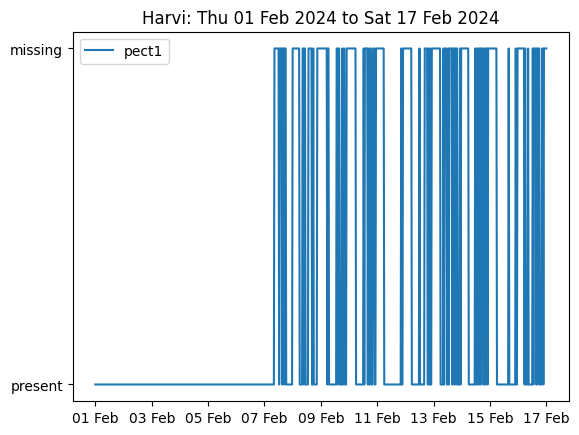

In [4]:
plot_harvi_range(start='2024-02-01 00:00', end='2024-02-17 00:00', cols=('pect1',))
# ('h1b', 'pect1', 'volts', 'h1d', 'exp', 'gep')
# ("imp", "exp", "gep", "gen", "h1d", "h1b")

"columns available: Index(['imp', 'exp', 'gen', 'pect1', 'v1', 'frq', 'volts', 'imp_kw', 'h1b',\n       'h1b_kw', 'h1d', 'h1d_kw', 'exp_kw', 'gep', 'nect1'],\n      dtype='str')"

Timedelta('1369 days 00:00:00')

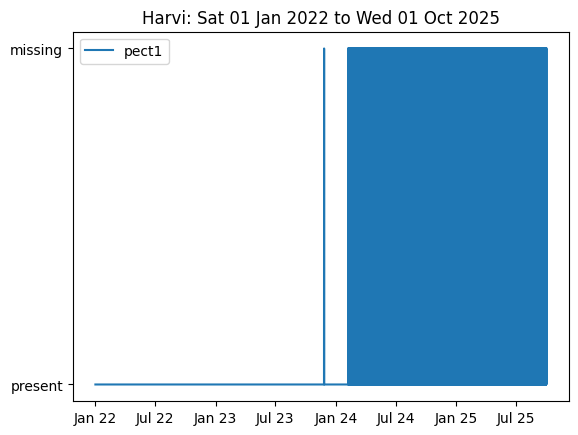

In [5]:
plot_harvi_range(start='2022-01-01 00:00', end='2025-10-01 00:00', cols=('pect1',))

"columns available: Index(['imp', 'h1b', 'nect1', 'v1', 'frq', 'volts', 'imp_kw', 'h1b_kw', 'h1d',\n       'h1d_kw', 'exp', 'exp_kw', 'gen', 'gep', 'pect1'],\n      dtype='str')"

Timedelta('6 days 23:00:00')

,pect1
2026-02-11 09:00:00+00:00,True
2026-02-11 09:30:00+00:00,True
2026-02-11 10:00:00+00:00,False
2026-02-11 10:30:00+00:00,False
2026-02-11 11:00:00+00:00,True


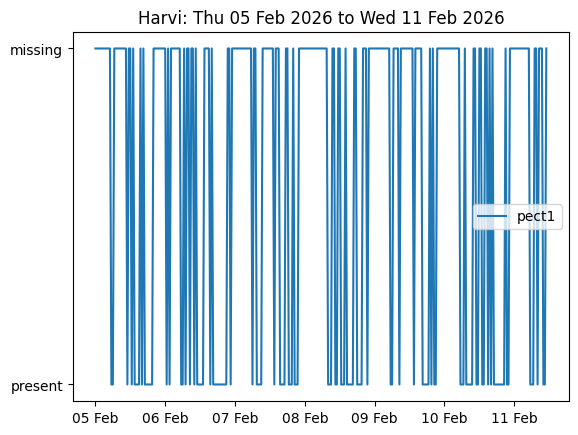

In [16]:
plot_harvi_range(start='2026-02-05 00:00', end='2026-02-11 23:00', cols=('pect1',))